In [1]:
from huggingface_hub import login, HfFolder
import os
huggingface_token = os.getenv('HUGGINGFACE_TOKEN')

login(token=huggingface_token, add_to_git_credential=True)

Token is valid (permission: read).
Your token has been saved in your configured git credential helpers (manager,store).
Your token has been saved to C:\Users\Zhenya\.cache\huggingface\token
Login successful


In [2]:

import os
import re
import shutil
import sys
import time
from dataclasses import dataclass, field
from functools import partial

from typing import Any, Dict, List, Optional, Union

import datasets
import evaluate
import numpy as np
import torch
import torch.nn as nn
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from datasets import (
    DatasetDict,
    IterableDataset,
    IterableDatasetDict,
    concatenate_datasets,
    interleave_datasets,
    load_dataset,
)

from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AddedToken,
    HfArgumentParser,
    Seq2SeqTrainingArguments,
    WhisperConfig,
    WhisperFeatureExtractor,
    WhisperForConditionalGeneration,
    WhisperProcessor,
    WhisperTokenizerFast,
    get_scheduler,
    set_seed,
)
from transformers.modeling_outputs import BaseModelOutput
from transformers.utils import check_min_version
from transformers.utils.versions import require_version


# Will error if the minimal version of Transformers is not installed. Remove at your own risks.
check_min_version("4.34.0.dev0")

require_version("datasets>=2.14.6", "To fix: `pip install --upgrade datasets`")

logger = get_logger(__name__)

In [3]:
from run_distillation import (ModelArguments, DataTrainingArguments, DistillationTrainingArguments,
    DataCollatorSpeechSeq2SeqWithPadding, convert_dataset_str_to_list,
    load_multiple_datasets, get_layers_to_supervise, sorted_checkpoints, rotate_checkpoints,
    get_last_checkpoint, get_parameter_names)

In [4]:
from run_short_form_eval import log_pred, log_metric

In [5]:
raw_datasets = DatasetDict()
# sampling_rate = 16_000
# 3. Load dataset
all_eval_datasets_list = []

# Mozila UK

def prepare_mozilla_uk_dataset(folder_path, split):
    split_dataset = datasets.load_from_disk(f'{folder_path}/{split}',) 
    split_dataset = split_dataset.rename_column("sentence", "text")
    split_dataset = split_dataset.remove_columns(
        set(split_dataset.features.keys()) - {"audio", "text", "whisper_transcript"}
        )
    return split_dataset

    
for split in ['test']:
    print(split)
    all_eval_datasets_list.append(
        prepare_mozilla_uk_dataset('dataset_saved/labeled', split)
        )
    
# Place for next dataset    

raw_datasets['eval'] = concatenate_datasets(all_eval_datasets_list)

test


In [54]:
import matplotlib.pyplot as plt

In [43]:
from IPython.display import Audio



{'audio': {'path': 'common_voice_uk_25651279.mp3',
  'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -2.83332047e-05, -1.70377934e-05, -2.60313645e-05]),
  'sampling_rate': 16000},
 'text': "Відтоді я встиг об'їхати увесь світ.",
 'whisper_transcript': [50258,
  50280,
  50359,
  50363,
  2348,
  9554,
  403,
  1435,
  1827,
  28669,
  740,
  4756,
  1906,
  3348,
  6,
  8045,
  1157,
  9585,
  1595,
  29225,
  4155,
  24947,
  13,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257]}

In [148]:
i = 0
sample_audio = raw_datasets['eval'][i]
sample_audio

{'audio': {'path': 'common_voice_uk_36819047.mp3',
  'array': array([ 6.36646291e-12, -5.68434189e-12,  7.56017471e-12, ...,
         -9.69655957e-06, -2.48929719e-05, -5.01926843e-06]),
  'sampling_rate': 16000},
 'text': 'Він хотів стягти її з вагончика.',
 'whisper_transcript': [50258,
  50263,
  50359,
  50363,
  9456,
  4492,
  585,
  3266,
  25217,
  20566,
  14803,
  3943,
  740,
  5583,
  1784,
  753,
  17286,
  13,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257,
  50257]}

array([ 6.36646291e-12, -5.68434189e-12,  7.56017471e-12, ...,
       -9.69655957e-06, -2.48929719e-05, -5.01926843e-06])

In [157]:
sample_feature = feature_extractor([sample_audio['audio']['array']], sampling_rate=16_000, return_tensors="pt")

In [166]:
sample_input_feature = sample_feature['input_features'].numpy()
sample_input_feature

array([[[-0.8220937, -0.8220937, -0.8220937, ..., -0.8220937,
         -0.8220937, -0.8220937],
        [-0.8220937, -0.8220937, -0.8220937, ..., -0.8220937,
         -0.8220937, -0.8220937],
        [-0.8220937, -0.8220937, -0.8220937, ..., -0.8220937,
         -0.8220937, -0.8220937],
        ...,
        [-0.8220937, -0.8220937, -0.8220937, ..., -0.8220937,
         -0.8220937, -0.8220937],
        [-0.8220937, -0.8220937, -0.8220937, ..., -0.8220937,
         -0.8220937, -0.8220937],
        [-0.8220937, -0.8220937, -0.8220937, ..., -0.8220937,
         -0.8220937, -0.8220937]]], dtype=float32)

In [162]:
import librosa
plt.figure(figsize=(10, 4))
plt.imshow(sample_input_feature[0], aspect='auto', origin='lower')
plt.title('Feature matrix')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Features')
plt.show()

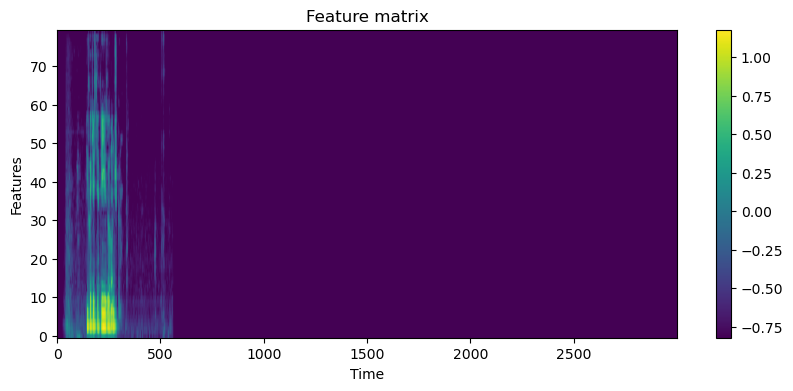

In [176]:
plt.figure(figsize=(10, 4))
plt.imshow(sample_input_feature[0], aspect='auto', origin='lower')
plt.title('Feature matrix')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Features')
plt.show()

In [181]:
max_label_length

128

In [183]:
from run_pseudo_labelling import DataCollatorSpeechSeq2SeqWithPadding

In [184]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=teacher_model.config.decoder_start_token_id,  # <|startoftranscript|>
    input_padding="longest",
    target_padding="max_length",
    max_target_length=max_label_length,
)


In [186]:
sample_input_feature

array([[[-0.8220937, -0.8220937, -0.8220937, ..., -0.8220937,
         -0.8220937, -0.8220937],
        [-0.8220937, -0.8220937, -0.8220937, ..., -0.8220937,
         -0.8220937, -0.8220937],
        [-0.8220937, -0.8220937, -0.8220937, ..., -0.8220937,
         -0.8220937, -0.8220937],
        ...,
        [-0.8220937, -0.8220937, -0.8220937, ..., -0.8220937,
         -0.8220937, -0.8220937],
        [-0.8220937, -0.8220937, -0.8220937, ..., -0.8220937,
         -0.8220937, -0.8220937],
        [-0.8220937, -0.8220937, -0.8220937, ..., -0.8220937,
         -0.8220937, -0.8220937]]], dtype=float32)

In [187]:
data_collator(sample_feature)

TypeError: string indices must be integers

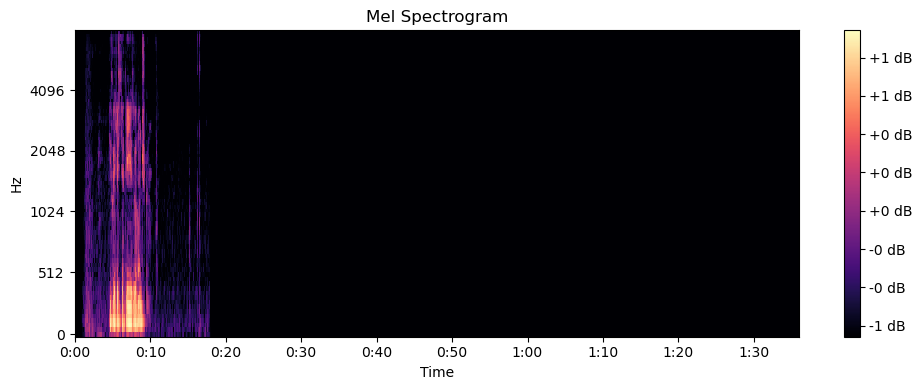

In [175]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=#model.config.decoder_start_token_id,  # <|startoftranscript|>
    input_padding="longest",
    target_padding="max_length",
    max_target_length=max_label_length,
)

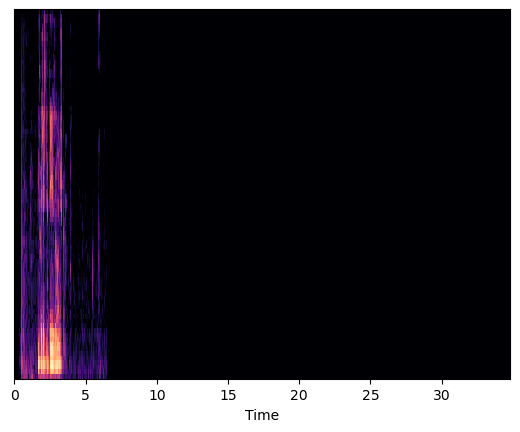

In [173]:
librosa.display.specshow(sample_input_feature[0], x_axis='time', sr=44100 )

In [147]:
for i in range(10):


    text = sample_audio['text']
    print(text)
    print( tokenizer.decode(tokenizer.encode(text)))

Він хотів стягти її з вагончика.
<|startoftranscript|><|notimestamps|>Він хотів стягти її з вагончика.<|endoftext|>
Відтоді я встиг об'їхати увесь світ.
<|startoftranscript|><|notimestamps|>Відтоді я встиг об'їхати увесь світ.<|endoftext|>
Пробачте: і тут лірика.
<|startoftranscript|><|notimestamps|>Пробачте: і тут лірика.<|endoftext|>
Приїхав дід, розказав бабі, що так і так.
<|startoftranscript|><|notimestamps|>Приїхав дід, розказав бабі, що так і так.<|endoftext|>
І тут наперед приготуйтеся
<|startoftranscript|><|notimestamps|>І тут наперед приготуйтеся<|endoftext|>
Він підійшов до дверей і постукав.
<|startoftranscript|><|notimestamps|>Він підійшов до дверей і постукав.<|endoftext|>
Але я хочу їхати коло вас.
<|startoftranscript|><|notimestamps|>Але я хочу їхати коло вас.<|endoftext|>
Однак на чужих робила, то й на вас буду.
<|startoftranscript|><|notimestamps|>Однак на чужих робила, то й на вас буду.<|endoftext|>
Не завжди так складається, як сподівається.
<|startoftranscript|><|n

In [140]:
tokenizer.decode(sample_audio['whisper_transcript'])

'<|startoftranscript|><|ru|><|transcribe|><|notimestamps|> Хочу стягивать ее из вагончика.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [45]:
print(sample_audio['text'])
Audio(sample_audio['audio']['array'], rate=16_000)


Відтоді я встиг об'їхати увесь світ.


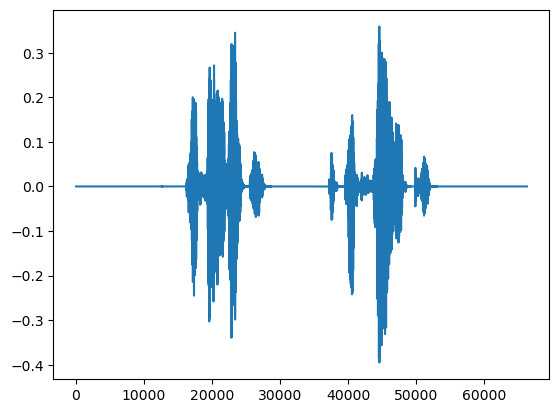

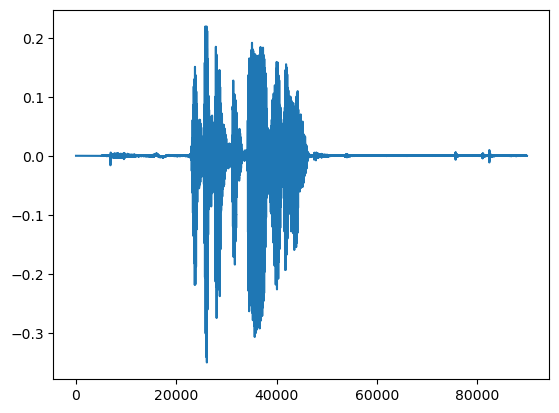

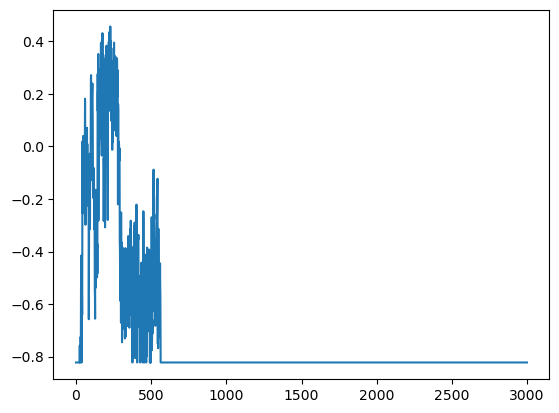

In [67]:
i = 0

raw_sample_audio = raw_datasets['eval'][i]
plt.plot(raw_sample_audio['audio']['array'])
plt.show()

vect_sample_audio = vectorized_datasets['eval'][i]
plt.plot(vect_sample_audio['input_features'][i])
plt.show()

In [ ]:
sample_audio

In [6]:
if DEBUG_MODE:=True :
    raw_datasets['eval'] = raw_datasets['eval'].select(range(100))
    

In [7]:
# 1. Parse input arguments
# We keep distinct sets of args, for cleaner separation of model/data/training related args
parser = HfArgumentParser((ModelArguments, DataTrainingArguments, DistillationTrainingArguments))

list_args = [
    '--model_name_or_path=./models_dir/student_moz_uk',
    # '--teacher_model_name_or_path=openai/whisper-medium',
    '--teacher_model_name_or_path=./local_whisper_medium',
    '--eval_steps=500',
    '--save_steps=500',
    '--warmup_steps=250',
    '--learning_rate=0.00001',
    '--lr_scheduler_type=constant_with_warmup',
    '--logging_steps=25',
    '--save_total_limit=3',
    '--max_steps=10000',
    # '--wer_threshold=None',
    '--per_device_train_batch_size=24',
    '--per_device_eval_batch_size=24',
    '--dataloader_num_workers=4',
    '--preprocessing_num_workers=4',
    '--ddp_timeout=7200',
    '--dtype=float16',
    '--do_train=True',
    '--do_eval=True',
    '--gradient_checkpointing=True',
    '--streaming=False',
    '--cache_dir=./model_cache/',

    '--overwrite_output_dir=True',
    '--output_dir=./result_distiling_4',
    '--freeze_encoder=True',
    '--language=uk',
    # '--=',
]

model_args, data_args, training_args = parser.parse_args_into_dataclasses(list_args)

In [8]:
%load_ext autoreload
%autoreload 1

# Specify that the init_accelerator module should be reloaded
%aimport src.init_accelerator
%aimport src.load_models
%aimport src.prepare_dataset

In [9]:
from src.init_accelerator import prepare_accelerator, create_rep_and_dir

In [10]:
accelerator, teacher_dtype= prepare_accelerator(training_args=training_args, data_args=data_args, logger=logger)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zekamrozek. Use `wandb login --relogin` to force relogin


04/17/2024 13:01:01 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
04/17/2024 13:01:01 - INFO - __main__ - Training/evaluation parameters DistillationTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=4,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=7200,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=True,
dtype=float16,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500.0,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
freeze_encoder=True,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},


In [11]:
last_checkpoint = None

In [12]:
create_rep_and_dir(accelerator, training_args)

In [13]:
from src.load_models import load_config_feature_ext_tokenizer, load_processor, load_whisper_model

In [14]:
model_args.teacher_model_name_or_path

'./local_whisper_medium'

In [103]:
tokenizer

WhisperTokenizerFast(name_or_path='./models_dir/student_moz_uk', vocab_size=50258, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|endoftext|>', '<|startoftranscript|>', '<|en|>', '<|zh|>', '<|de|>', '<|es|>', '<|ru|>', '<|ko|>', '<|fr|>', '<|ja|>', '<|pt|>', '<|tr|>', '<|pl|>', '<|ca|>', '<|nl|>', '<|ar|>', '<|sv|>', '<|it|>', '<|id|>', '<|hi|>', '<|fi|>', '<|vi|>', '<|he|>', '<|uk|>', '<|el|>', '<|ms|>', '<|cs|>', '<|ro|>', '<|da|>', '<|hu|>', '<|ta|>', '<|no|>', '<|th|>', '<|ur|>', '<|hr|>', '<|bg|>', '<|lt|>', '<|la|>', '<|mi|>', '<|ml|>', '<|cy|>', '<|sk|>', '<|te|>', '<|fa|>', '<|lv|>', '<|bn|>', '<|sr|>', '<|az|>', '<|sl|>', '<|kn|>', '<|et|>', '<|mk|>', '<|br|>', '<|eu|>', '<|is|>', '<|hy|>', '<|ne|>', '<|mn|>', '<|bs|>', '<|kk|>', '<|sq|>', '<|sw|>', '<|gl|>', '<|mr|>', '<|pa

In [15]:
config, feature_extractor, tokenizer = load_config_feature_ext_tokenizer(model_args)

processor = load_processor(model_args.model_name_or_path, model_args=model_args)

teacher_model = load_whisper_model(model_args.teacher_model_name_or_path, model_args=model_args, dtype=teacher_dtype)
# teacher_model.save_pretrained('./local_whisper_medium')

student_model = load_whisper_model(model_args.model_name_or_path, model_args=model_args, dtype=teacher_dtype)

loading configuration file ./models_dir/student_moz_uk\config.json
Model config WhisperConfig {
  "_name_or_path": "./local_whisper_medium",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "apply_spec_augment": false,
  "architectures": [
    "WhisperForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "begin_suppress_tokens": [
    220,
    50257
  ],
  "bos_token_id": 50257,
  "classifier_proj_size": 256,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 2,
  "decoder_start_token_id": 50258,
  "dropout": 0.0,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 24,
  "eos_token_id": 50257,
  "forced_decoder_ids": [
    [
      1,
      50259
    ],
    [
      2,
      50359
    ],
    [
      3,
      50363
    ]
  ],
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "mask_feature_length": 10,
  "mask_feature_min_masks": 0,
  "

In [16]:
teacher_model.eval();
student_model.eval();

In [17]:
from src.prepare_dataset import prepare_vectorized_dataset, prepare_normilazer

In [18]:
dataloader_num_workers=training_args.dataloader_num_workers

language = data_args.language

In [19]:
normalizer = prepare_normilazer(language=data_args.language, tokenizer=tokenizer)

In [20]:
data_args.max_label_length

128

In [21]:
vectorized_datasets, max_label_length = prepare_vectorized_dataset(
    data_args=data_args,
    model=teacher_model, feature_extractor=feature_extractor, tokenizer=tokenizer,
    raw_datasets=raw_datasets, all_eval_splits=['eval'])

128
initializing prepare_vectorized_dataset
preprocessing dataset
['audio', 'text', 'whisper_transcript']


In [22]:
metric = evaluate.load("wer")

def compute_metrics(preds, labels):
    # replace padded labels by the padding token
    for idx in range(len(labels)):
        labels[idx][labels[idx] == -100] = tokenizer.pad_token_id

    pred_str = tokenizer.batch_decode(preds, skip_special_tokens=True, decode_with_timestamps=return_timestamps)
    # we do not want to group tokens when computing the metrics
    label_str = tokenizer.batch_decode(labels, skip_special_tokens=True)
    wer_ortho = 100 * metric.compute(predictions=pred_str, references=label_str)

    # normalize everything and re-compute the WER
    norm_pred_str = [normalizer(pred) for pred in pred_str]
    norm_label_str = [normalizer(label) for label in label_str]
    # for logging, we need the pred/labels to match the norm_pred/norm_labels, so discard any filtered samples here
    pred_str = [pred_str[i] for i in range(len(norm_pred_str)) if len(norm_label_str[i]) > 0]
    label_str = [label_str[i] for i in range(len(norm_label_str)) if len(norm_label_str[i]) > 0]
    # filtering step to only evaluate the samples that correspond to non-zero normalized references:
    norm_pred_str = [norm_pred_str[i] for i in range(len(norm_pred_str)) if len(norm_label_str[i]) > 0]
    norm_label_str = [norm_label_str[i] for i in range(len(norm_label_str)) if len(norm_label_str[i]) > 0]

    wer = 100 * metric.compute(predictions=norm_pred_str, references=norm_label_str)

    return {"wer": wer, "wer_ortho": wer_ortho}, pred_str, label_str, norm_pred_str, norm_label_str

In [23]:
return_timestamps = False

In [24]:
decoder_prev_token_id = tokenizer.all_special_ids[-3]

In [25]:
per_device_eval_batch_size = int(training_args.per_device_eval_batch_size)

data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=teacher_model.config.decoder_start_token_id,  # <|startoftranscript|>
    decoder_prev_token_id=decoder_prev_token_id,
    input_padding="longest",
    target_padding="max_length",
    max_target_length=max_label_length,
)

# 14. Define generation arguments - we need to do this before we wrap the models in DDP
# so that we can still access the configs
num_beams = (
    training_args.generation_num_beams
    if training_args.generation_num_beams is not None
    else getattr(teacher_model.generation_config, "num_beams", 1)
)
max_new_tokens = training_args.generation_max_length if training_args.generation_max_length is not None else max_label_length

gen_kwargs = {
    "max_new_tokens": max_new_tokens,
    "num_beams": num_beams,
    "return_timestamps": return_timestamps,
}

In [26]:
student_model, teacher_model = accelerator.prepare(
    student_model, teacher_model
)

In [27]:
def eval_step(model, split="eval"):
    # ======================== Evaluating ==============================
    eval_preds = []
    eval_labels = []
    eval_start = time.time()

    eval_loader = DataLoader(
        vectorized_datasets[split],
        batch_size=per_device_eval_batch_size,
        collate_fn=data_collator,
        num_workers=dataloader_num_workers,
        pin_memory=True,
    )

    eval_loader = accelerator.prepare(eval_loader)
    batches = tqdm(eval_loader, desc=f"Evaluating {split}...", disable=not accelerator.is_local_main_process)

    # make the split name pretty for librispeech etc
    split = split.replace(".", "-").split("/")[-1]

    for step, batch in enumerate(batches):
        # Generate predictions and pad to max generated length
        generate_fn = model.module.generate if accelerator.num_processes > 1 else model.generate
        generated_ids = generate_fn(batch["input_features"].to(dtype=teacher_dtype), **gen_kwargs)
        generated_ids = accelerator.pad_across_processes(generated_ids, dim=1, pad_index=tokenizer.pad_token_id)
        # Gather all predictions and targets
        generated_ids, labels = accelerator.gather_for_metrics((generated_ids, batch["labels"]))
        eval_preds.extend(generated_ids.cpu().numpy())
        eval_labels.extend(labels.cpu().numpy())

    accelerator.wait_for_everyone()
    eval_time = time.time() - eval_start

    # compute WER metric for eval sets
    wer_metric, pred_str, label_str, norm_pred_str, norm_label_str = compute_metrics(eval_preds, eval_labels)
    wer_desc = " ".join([f"Eval {key}: {value} |" for key, value in wer_metric.items()])
    logger.info(wer_desc)
    # Save metrics + predictions
    log_metric(
        accelerator,
        metrics=wer_metric,
        train_time=eval_time,
        prefix=split,
    )
    log_pred(
        accelerator,
        pred_str,
        label_str,
        norm_pred_str,
        norm_label_str,
        prefix=split,
    )

In [28]:
split = 'eval'
eval_step(model=student_model, split=split)
eval_step(model=teacher_model, split=split)



Evaluating eval...: 100%|██████████| 5/5 [00:25<00:00,  5.09s/it]
04/17/2024 13:01:31 - INFO - __main__ - Eval wer: 100.0 | Eval wer_ortho: 100.0 |
Evaluating eval...: 100%|██████████| 5/5 [00:25<00:00,  5.04s/it]
04/17/2024 13:01:58 - INFO - __main__ - Eval wer: 125.77903682719547 | Eval wer_ortho: 124.29775280898876 |


In [ ]:
accelerator.end_training()

In [68]:
eval_preds = []
eval_labels = []
eval_start = time.time()

eval_loader = DataLoader(
    vectorized_datasets[split],
    batch_size=1,
    collate_fn=data_collator,
    num_workers=1,
    pin_memory=True,
)

In [69]:
eval_loader = accelerator.prepare(eval_loader)
batches = tqdm(eval_loader, desc=f"Evaluating {split}...", disable=not accelerator.is_local_main_process)

# make the split name pretty for librispeech etc
split = split.replace(".", "-").split("/")[-1]

Evaluating eval...:   0%|          | 0/100 [00:00<?, ?it/s]

In [97]:
model = teacher_model
# model = student_model

In [138]:
gen_kwargs

{'max_new_tokens': 128, 'num_beams': 1, 'return_timestamps': False}

In [136]:
for step, batch in enumerate(batches):
    pass

# Generate predictions and pad to max generated length
generate_fn = model.module.generate if accelerator.num_processes > 1 else model.generate
generated_ids = generate_fn(batch["input_features"].to(dtype=teacher_dtype), **gen_kwargs, forced_eos_token_id="uk")
generated_ids = accelerator.pad_across_processes(generated_ids, dim=1, pad_index=tokenizer.pad_token_id)
# Gather all predictions and targets
generated_ids, labels = accelerator.gather_for_metrics((generated_ids, batch["labels"]))
eval_preds.extend(generated_ids.cpu().numpy())
eval_labels.extend(labels.cpu().numpy())

In [137]:
tokenizer.decode(generated_ids[0], skip_special_tokens=True, decode_with_timestamps=True)

' She gave him a bottle of water.'

In [117]:
tokenizer.batch_decode([50280], decode_with_timestamps=return_timestamps)

['<|uk|>']

In [108]:
# Assuming this is your list of numbers
numbers = [50258, 50263, 50359, 50363, 9456, 4492, 585, 3266, 25217, 20566, 14803, 3943,
           740, 5583, 1784, 753, 17286, 13, 50257, 50257, 50257, 50257, 50257, 50257,
           50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
           50257, 50257, 50257, 50257, 50257]



In [125]:
tokenizer.encode("Hello, how are you?")

[50258, 50363, 15947, 11, 577, 366, 291, 30, 50257]

In [129]:
processor(numbers)

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


{'input_features': [array([[3.7932985, 3.3707695, 1.7932985, ..., 1.7932985, 1.7932985,
        1.7932985],
       [3.738668 , 3.3560138, 1.7932985, ..., 1.7932985, 1.7932985,
        1.7932985],
       [3.6353889, 3.3345256, 1.7932985, ..., 1.7932985, 1.7932985,
        1.7932985],
       ...,
       [2.937846 , 2.6011872, 1.7932985, ..., 1.7932985, 1.7932985,
        1.7932985],
       [3.0444698, 2.6210778, 1.7932985, ..., 1.7932985, 1.7932985,
        1.7932985],
       [3.06539  , 2.6825266, 1.7932985, ..., 1.7932985, 1.7932985,
        1.7932985]], dtype=float32)]}

In [135]:
custom_processor = WhisperProcessor.from_pretrained(
    model_args.model_name_or_path,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    token=model_args.token,
    language='uk',
)

loading configuration file ./models_dir/student_moz_uk\preprocessor_config.json
Feature extractor WhisperFeatureExtractor {
  "chunk_length": 30,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

loading file vocab.json
loading file tokenizer.json
loading file merges.txt
loading file normalizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [133]:
model_args

ModelArguments(model_name_or_path='./models_dir/student_moz_uk', teacher_model_name_or_path='./local_whisper_medium', config_name=None, tokenizer_name=None, feature_extractor_name=None, cache_dir='./model_cache/', use_fast_tokenizer=True, model_revision='main', subfolder='', token=None)

In [127]:
tokenizer.decode(tokenizer.encode("Привіт як ти?", language='uk'))

TypeError: PreTrainedTokenizerFast._batch_encode_plus() got an unexpected keyword argument 'language'

In [123]:
tokenizer.encode("Привет как ти?", skip_special_tokens=False)

TypeError: PreTrainedTokenizerFast._batch_encode_plus() got an unexpected keyword argument 'skip_special_tokens'

In [109]:
tokenizer.decode(numbers, language = 'uk')

'<|startoftranscript|><|ru|><|transcribe|><|notimestamps|> Хочу стягивать ее из вагончика.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [99]:
tokenizer.decode(labels[0][labels[0]>0], skip_special_tokens=True, decode_with_timestamps=True)

'Вона подала йому кухоль з водою.'

In [100]:
# teacher_model

In [101]:
tokenizer.decode(generated_ids[0], skip_special_tokens=True, decode_with_timestamps=True)

' She gave him a bottle of water.'

In [102]:
generated_ids

tensor([[50258, 50259, 50359, 50363,  1240,  2729,   796,   257,  7817,   295,
          1281,    13, 50257]], device='cuda:0')

In [ ]:








accelerator.wait_for_everyone()
eval_time = time.time() - eval_start

# compute WER metric for eval sets
wer_metric, pred_str, label_str, norm_pred_str, norm_label_str = compute_metrics(eval_preds, eval_labels)
wer_desc = " ".join([f"Eval {key}: {value} |" for key, value in wer_metric.items()])
logger.info(wer_desc)
# Save metrics + predictions
log_metric(
    accelerator,
    metrics=wer_metric,
    train_time=eval_time,
    prefix=split,
)
log_pred(
    accelerator,
    pred_str,
    label_str,
    norm_pred_str,
    norm_label_str,
    prefix=split,
)